<h1>¡Bienvenido a mi exploración del fraude con tarjetas de crédito!</h1>

En este kernel haré algunas exploraciones tratando de comprender los patrones de transacciones fraudulentas y luego implementaré algunos modelos de aprendizaje automático.<br>

Implementaré una técnica llamada SMOTE, modelos supervisados, algoritmos de aprendizaje semi supervisados y un modelo de aprendizaje profundo.

<h2>Introducción al conjunto de datos</h2>

Los conjuntos de datos contienen transacciones con tarjetas de crédito realizadas en septiembre de 2013 por titulares de tarjetas europeos. Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está muy desequilibrado: la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene únicamente variables de entrada numéricas que son el resultado de una transformación PCA. Lamentablemente, por cuestiones de confidencialidad, no podemos proporcionar las características originales ni información más general sobre los datos. Las características V1, V2,... V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Time' y 'Amount'. La característica 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Amount' es el monto de la transacción; Esta característica se puede utilizar, por ejemplo, para el aprendizaje sensible al costo. La característica 'Class' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Dada la relación de desequilibrio de clases, recomendamos medir la precisión utilizando el área bajo la curva de recuperación de precisión (AUPRC). La precisión de la matriz de confusión no es significativa para una clasificación desequilibrada.

El conjunto de datos se recopiló y analizó durante una colaboración de investigación de Worldline y el Machine Learning Group (http://mlg.ulb.ac.be) de la ULB (Université Libre de Bruxelles) sobre minería de big data y detección de fraude. Más detalles sobre proyectos actuales y pasados sobre temas relacionados están disponibles en http://mlg.ulb.ac.be/BruFence y http://mlg.ulb.ac.be/ARTML

Cita: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson y Gianluca Bontempi. Calibración de probabilidad con submuestreo para clasificación desequilibrada. En Simposio sobre Inteligencia Computacional y Minería de Datos (CIDM), IEEE, 2015.

## OBJETIVO

Exploraré la distribución de datos, ya que se trata de casi todas las características numéricas que se estandarizaron.

Usaré este Kernel para implementar algunos modelos de aprendizaje automático como estudio que me resulte práctico. Este es el objetivo principal.

<h2>Comencemos a importar las bibliotecas y buscar los datos</h2>

In [1]:
import pandas as pd #To hand with data 
import numpy as np #To math 
import seaborn as sns #to visualization
import matplotlib.pyplot as plt # to plot the graphs
import matplotlib.gridspec as gridspec # to do the grid of plots

In [2]:
#loading the data
df_credit = pd.read_csv("../input/creditcard.csv")

In [3]:
#looking the how data looks
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#looking the type and searching for null values
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
# The data is stardarized, I will explore them later
#For now I will look the "normal" columns
df_credit[["Time","Amount","Class"]].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


<h2>En primer lugar, exploraré a través de 3 columnas diferentes:</h2>
- Tiempo
- Cantidad
- Clase

Distribuition of Normal(0) and Frauds(1): 
0    284315
1       492
Name: Class, dtype: int64


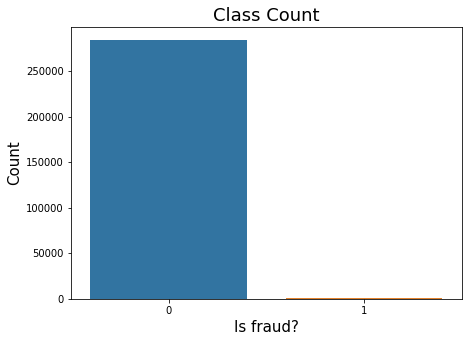

In [6]:
#Lets start looking the difference by Normal and Fraud transactions
print("Distribuition of Normal(0) and Frauds(1): ")
print(df_credit["Class"].value_counts())

plt.figure(figsize=(7,5))
sns.countplot(df_credit['Class'])
plt.title("Class Count", fontsize=18)
plt.xlabel("Is fraud?", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

Tenemos unos datos claramente desequilibrados.<br>
Es muy común cuando se trata de fraudes... <br>

<b>Primero</b> exploraré un poco el tiempo y la cantidad. <br>
<b>Segundo</b> exploraré las características de V, que son PCA.

## Funciones de tiempo y algunas características de ingeniería
Como nuestra función de tiempo está en segundos, la transformaremos en minutos y horas para comprender mejor los patrones.

In [7]:
timedelta = pd.to_timedelta(df_credit['Time'], unit='s')
df_credit['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df_credit['Time_hour'] = (timedelta.dt.components.hours).astype(int)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


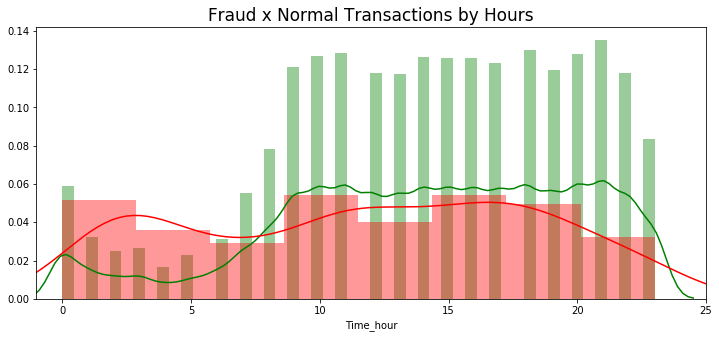

In [8]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df_credit[df_credit['Class'] == 0]["Time_hour"], 
             color='g')
sns.distplot(df_credit[df_credit['Class'] == 1]["Time_hour"], 
             color='r')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

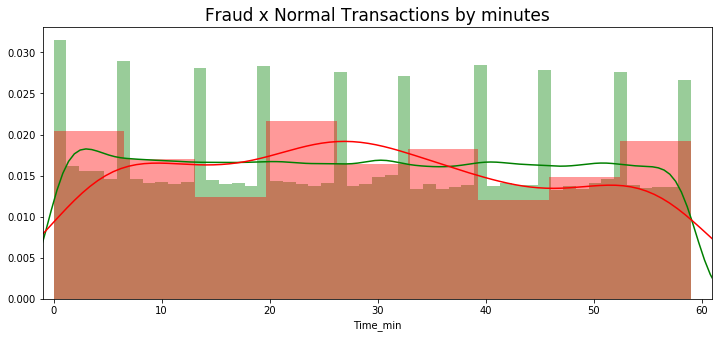

In [9]:
#Exploring the distribuition by Class types throught hours and minutes
plt.figure(figsize=(12,5))
sns.distplot(df_credit[df_credit['Class'] == 0]["Time_min"], 
             color='g')
sns.distplot(df_credit[df_credit['Class'] == 1]["Time_min"], 
             color='r')
plt.title('Fraud x Normal Transactions by minutes', fontsize=17)
plt.xlim([-1,61])
plt.show()

- Distribución interesante, pero no parece un patrón de acción claro.

## Mirando las estadísticas de nuestros fraudes de clase de Cantidad y transacciones normales

In [10]:
#To clearly the data of frauds and no frauds
df_fraud = df_credit[df_credit['Class'] == 1]
df_normal = df_credit[df_credit['Class'] == 0]

print("Fraud transaction statistics")
print(df_fraud["Amount"].describe())
print("\nNormal transaction statistics")
print(df_normal["Amount"].describe())

Fraud transaction statistics
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal transaction statistics
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Interesante. <br>
Usando esta información filtraré los valores para buscar Cantidad por Clase <br>
Filtraré las cantidades "normales" por 3.000

In [13]:
#Feature engineering to a better visualization of the values
df_credit['Amount_log'] = np.log(df_credit.Amount + 0.01)

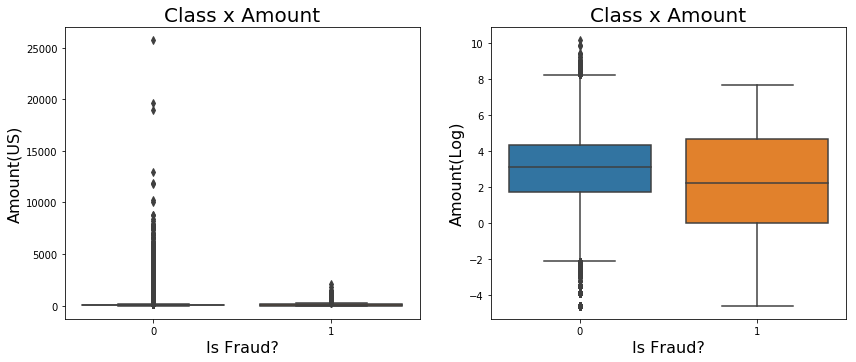

In [14]:
plt.figure(figsize=(14,6))
#I will explore the Amount by Class and see the distribuition of Amount transactions
plt.subplot(121)
ax = sns.boxplot(x ="Class",y="Amount",
                 data=df_credit)
ax.set_title("Class x Amount", fontsize=20)
ax.set_xlabel("Is Fraud?", fontsize=16)
ax.set_ylabel("Amount(US)", fontsize = 16)

plt.subplot(122)
ax1 = sns.boxplot(x ="Class",y="Amount_log", data=df_credit)
ax1.set_title("Class x Amount", fontsize=20)
ax1.set_xlabel("Is Fraud?", fontsize=16)
ax1.set_ylabel("Amount(Log)", fontsize = 16)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

Podemos ver una ligera diferencia en la cantidad de registros de nuestras dos Clases. <br>
El IQR de las transacciones fraudulentas es más alto que el de las transacciones normales, pero las transacciones normales tienen valores más altos.

### Looking a scatter plot of the Time_min distribuition by Amount

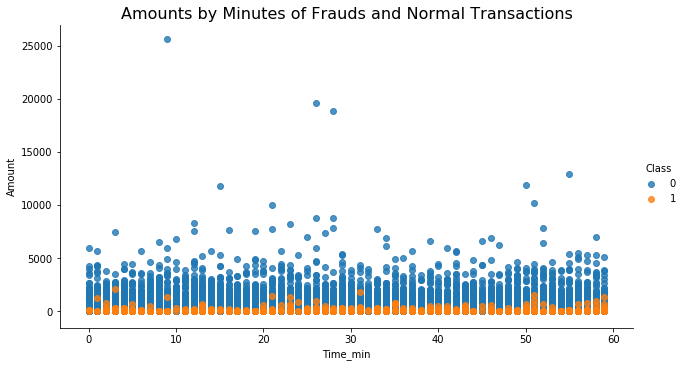

In [15]:
#Looking the Amount and time distribuition of FRAUD transactions
ax = sns.lmplot(y="Amount", x="Time_min", fit_reg=False,aspect=1.8,
                data=df_credit, hue='Class')
plt.title("Amounts by Minutes of Frauds and Normal Transactions",fontsize=16)
plt.show()

### Looking a scatter plot of the Time_hour distribuition by Amount

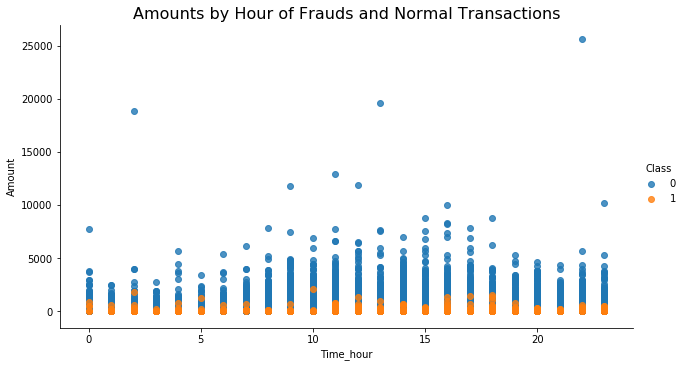

In [16]:
ax = sns.lmplot(y="Amount", x="Time_hour", fit_reg=False,aspect=1.8,
                data=df_credit, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)

plt.show()

<h2>Usaré boxplot para buscar diferentes distribuciones: </h2>
- Estamos buscando características que diverjan de la distribución normal.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


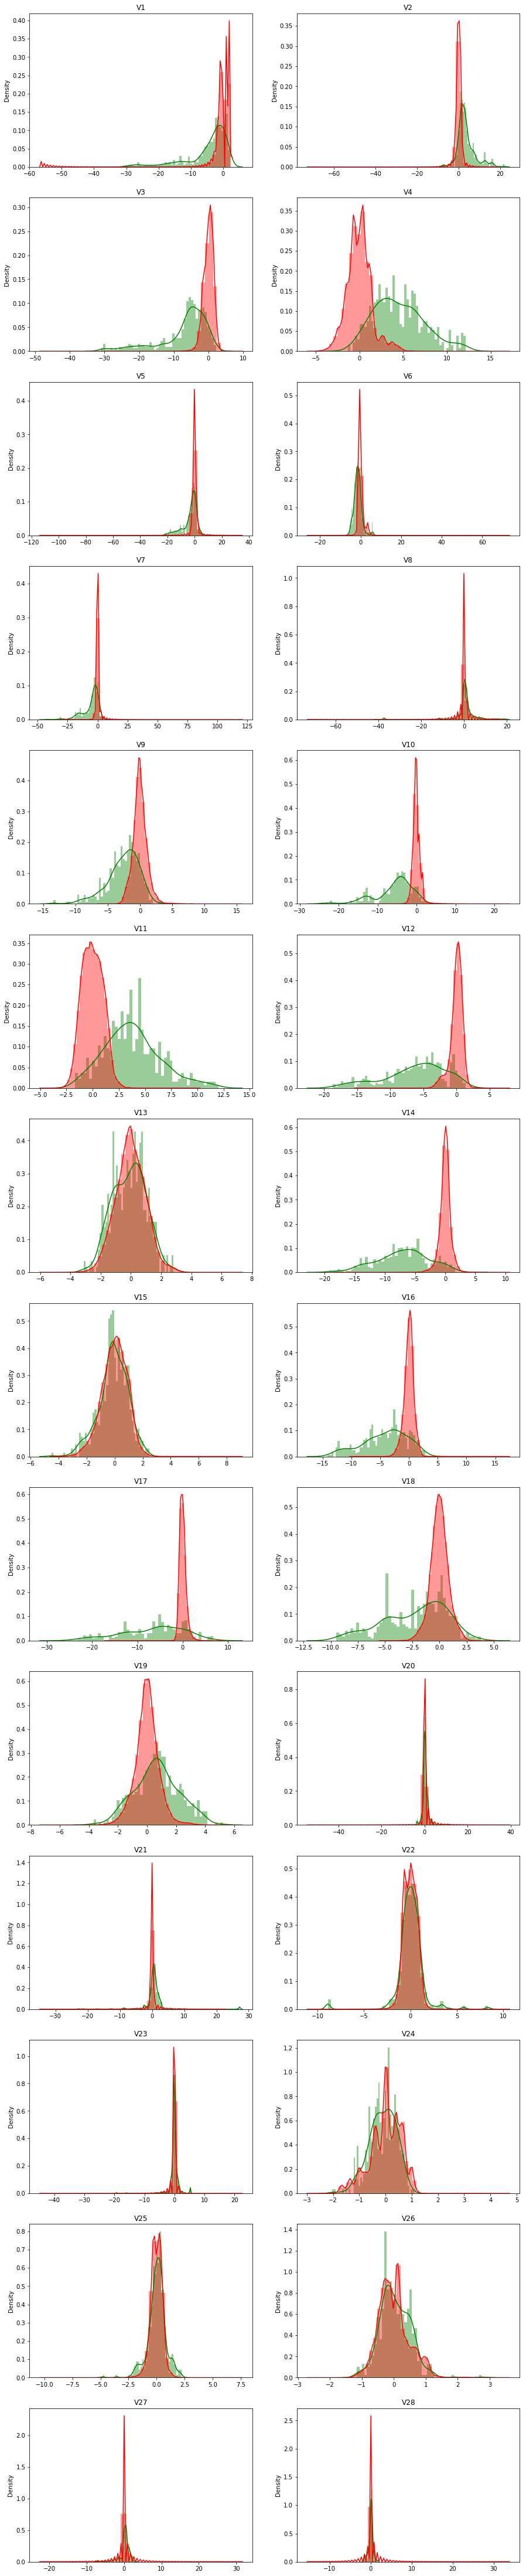

In [17]:
#Looking the V's features
columns = df_credit.iloc[:,1:29].columns

frauds = df_credit.Class == 1
normals = df_credit.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(df_credit[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df_credit[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
    sns.distplot(df_credit[col][normals], bins = 50, color='r') #Will receive the "ocean" color
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

Podemos ver una distribución diferente interesante en algunas de nuestras funciones como V4, V9, V16, V17 y muchas más. <br> 

## Selecciones de funciones

In [18]:
#I will select the variables where fraud class have a interesting behavior and might can help us predict

df_credit = df_credit[["Time_hour","Time_min","V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount","Class"]]

## Algunas características de ingeniería

In [19]:
df_credit.Amount = np.log(df_credit.Amount + 0.001)

In [20]:
#Looking the final df
df_credit.head()

,Time_hour,Time_min,V2,V3,V4,V9,V10,V11,V12,V14,V16,V17,V18,V19,V27,Amount,Class
0,0,0,-0.072781,2.536347,1.378155,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.133558,5.008105,0
1,0,0,0.266151,0.166480,0.448154,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.008983,0.989913,0
2,0,0,-1.340163,1.773209,0.379780,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,-0.055353,5.936641,0
3,0,0,-0.185226,1.792993,-0.863291,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,0.062723,4.816249,0
4,0,0,0.877737,1.548718,0.403034,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.219422,4.248367,0


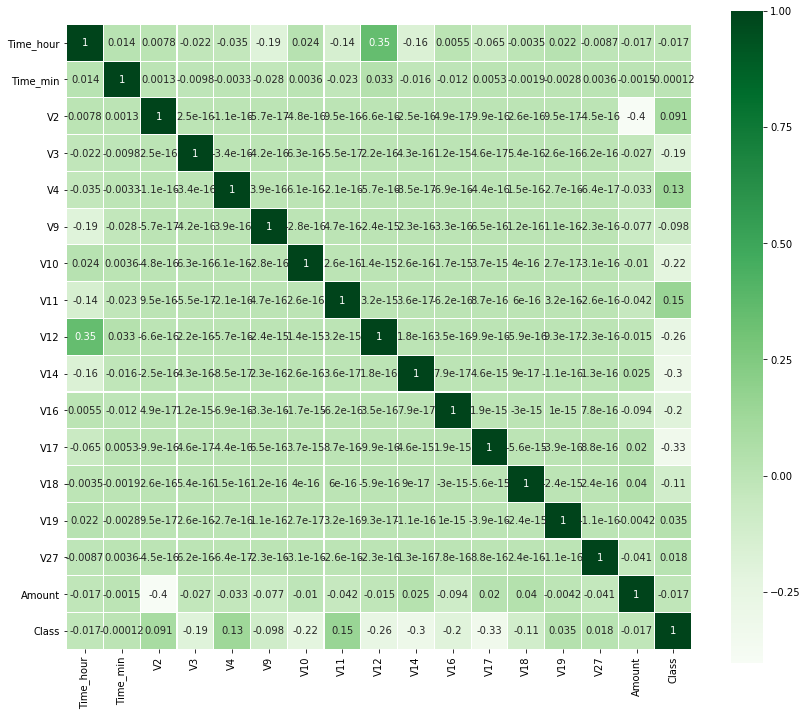

In [21]:
colormap = plt.cm.Greens

plt.figure(figsize=(14,12))

sns.heatmap(df_credit.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap = colormap, linecolor='white', annot=True)
plt.show()

## Preprocessing

In [22]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb # To do our transformation in a unique time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
X = df_credit.drop(["Class"], axis=1).values #Setting the X to do the split
y = df_credit["Class"].values # transforming the values in array

In [24]:
# the function that we will use to better evaluate the model
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.20)

classifier = RandomForestClassifier

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), \
                                   classifier(random_state=42))

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 284315, 1: 492})
SMOTE data distribution: Counter({0: 284315, 1: 284315})


## Evaluación del modelo SMOTE + Random Forest

In [25]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + RandomForest classification", y_test, smote_prediction)

Confusion Matrix: 
[[56863    15]
 [   13    71]]

SMOTE Pipeline Score 0.9995084442259752

SMOTE + RandomForest classification
accuracy: 0.9995084442259752
precision: 0.8255813953488372
recall: 0.8452380952380952
f2: 0.8412322274881516


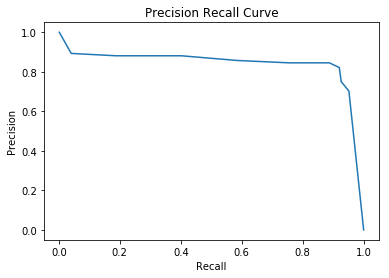

In [26]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

# Esta curva ROC es una curva sobreajustada, ¿cómo puedo solucionar este problema y obtener una curva correcta?

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [28]:
#params of the model
param_grid = {"max_depth": [3,5, None],
              "n_estimators":[3,5,10],
              "max_features": [5,6,7,8]}

# Creating the classifier
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1 )

In [29]:
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=3, verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, None], 'n_estimators': [3, 5, 10], 'max_features': [5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [30]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7843718777184991
{'max_depth': 5, 'max_features': 7, 'n_estimators': 10}


In [31]:
# Running the fit
rf = RandomForestClassifier(max_depth=5, max_features = 7, n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
# Printing the Training Score
print("Training score data: ")
print(rf.score(X_train, y_train))

Training score data: 
0.9995040488051088


In [33]:
#Testing the model 
#Predicting by X_test
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print_results("RF classification", y_test, y_pred)

[[56870     8]
 [   20    64]]
RF classification
accuracy: 0.9995084442259752
precision: 0.8888888888888888
recall: 0.7619047619047619
f2: 0.7843137254901961


## Gráfico de importancia de características

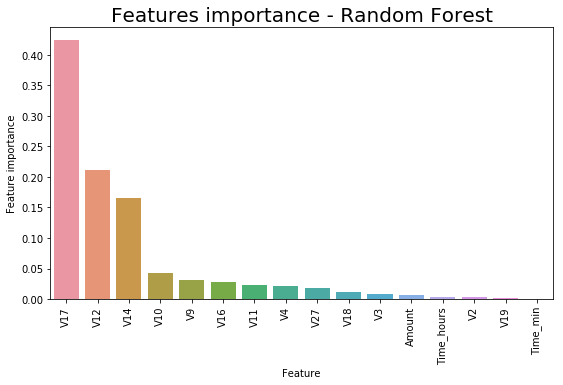

In [34]:
features = ["Time_min", 'Time_hours',"V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount"]

# Credits to Gabriel Preda
# https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models
plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

Las 4 características principales son V17, V14, V12, V10 y corresponden al 75% del total.

Además, la puntuación f2, que es la mediana de la recuperación y la precisión, tiene un valor considerable.

## CURVA ROC - Random Forest

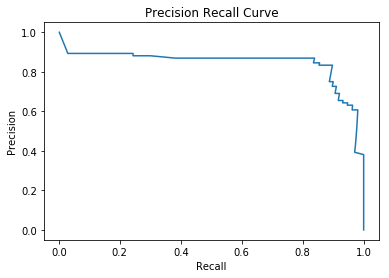

In [35]:
#Predicting proba
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [36]:
results = cross_val_score(rf,X_train, y_train, cv=10, scoring='recall')
results

array([0.75609756, 0.73170732, 0.73170732, 0.68292683, 0.7804878 ,
       0.7804878 , 0.75609756, 0.80487805, 0.8       , 0.775     ])

## Modelado de regresión logística con hiperparámetros

In [37]:
param_grid = {'C': [0.01, 0.1, 1, 10],
             'penalty':['l1', 'l2']}

logreg = LogisticRegression(random_state=2)

grid_search_lr = GridSearchCV(logreg, param_grid=param_grid, scoring='recall', cv=5)

grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [39]:
# The best recall obtained
print(grid_search_lr.best_score_)
#Best parameter on trainning set
print(grid_search_lr.best_params_)

0.602830517682702
{'C': 1, 'penalty': 'l2'}


### Estableciendo los mejores parámetros como parámetros de nuestro modelo.

In [40]:
# Creating the model 
logreg = LogisticRegression(C=10, penalty='l2',random_state=2)

#Fiting the model
logreg.fit(X_train, y_train)
           
# Printing the Training Score
print("Cross Validation of X and y Train: ")
print(cross_val_score(logreg,X_train, y_train, cv=5, scoring='recall'))

Cross Validation of X and y Train: 
[0.58536585 0.58536585 0.70731707 0.60493827 0.5308642 ]


In [41]:
# Predicting with the best params
y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("")
print_results("LogReg classification", y_test, y_pred)

[[56870     8]
 [   28    56]]

LogReg classification
accuracy: 0.9993679997191109
precision: 0.875
recall: 0.6666666666666666
f2: 0.7


El 70 % de precisión no es tan malo, pero encontramos un valor alto en el modelo Random Forest.

## Curva de recuperación de precisión de regresión logística

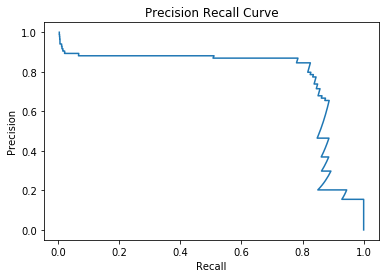

In [42]:
#Predicting proba
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

# CONCLUSIÓN:
Los valores más altos de las transacciones normales son 25691,16, mientras que los de las transacciones fraudulentas son solo 2125,87. <br>
El valor promedio de las transacciones normales es pequeño (USD 88,29) que el de las transacciones fraudulentas que es USD 122,21.


Obtuvimos la mejor puntuación cuando utilizamos SMOTE (OverSampling) + RandomForest, que obtuvo una puntuación f2 de 0,8669~

Esta es una diferencia considerable con respecto al segundo mejor modelo, que es 0.8252, que utiliza solo RandomForests con algunos hiperparámetros.

El peor modelo fue Logreg, donde utilicé GridSearchCV para ajustar los mejores parámetros y predecir dónde estaba la recuperación ~0,6666 y f2 ~0,70.


